# YouTube popularity predictor (Part 3): Model evaluation

In the previous notebook I showed how the title and description of a YouTube video can be combined with its category identifier and the name of the channel to generate features for machine learning models. We first tokenised the text information using byte-pair encoding, then further processed them into tf-idf vectors: the tokenised text was converted to numerical vectors containing a frequency count of each token in each sample, weighted by the frequency of the token in the corpus of training texts. We looked at linear regression and five classification models: multinomial naive Bayes, K-nearest neighbours, support vector machine, logistic regression, and the perceptron algorithm. Due to the features numbering in the millions, which is hundreds of times larger than the training data, it was necessary to apply statistical regularisation and perform hyperparameter tuning for each of the models. Once the models were built, I then further tried to improve on their accuracy by using two techniques: probability calibration and stacking.

In this notebook I'll evaluate all of the models on the test data and see how they perform compared to the previous cross-validation scores. The test data has so far been unseen: none of it was used to build the models. Let's first load the test data:

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import gcsfs

test = pd.read_csv('gs://yt_popularity_predictor/data/test.csv')
test

,channel_title,video_category,video_title,video_description,months,video_view_count,label
0,RG LECTURES,27,MHTCET FULL REVISION ONE SHOT ALL FORMULAS - P...,MHTCET PHYSICS FULL COMPLETE ONE SHOT REVISION...,11,5.238984,1
1,FuTechs,28,Tony Robbin and Robot conversation Relationshi...,"Speaker :Anthony Jay Robbins (né Mahavoric, bo...",10,4.364063,0
2,That Chemist,27,Nobel Prize in Chemistry 2022 (Recap),The Nobel Prize in Chemistry for 2022 has been...,18,4.484656,0
3,SCIENCE FUN For Everyone!,27,Friction Fun Friction Science Experiment,Have fun exploring friction with this easy sci...,36,4.503437,0
4,Michigan Medicine,26,Deconstructing the Legitimization of Acupunctu...,"Rick Harris, PhD\nAssociate Professor, Anesthe...",57,4.632467,0
...,...,...,...,...,...,...,...
6328,CARB ACADEMY,27,Class 8th Maths Chapter 1 l NCERT EXERCISE-1.1...,Class 8th Maths Chapter 1 l NCERT EXERCISE-1.1...,16,5.496467,1
6329,Rafael Verdonck's World,22,Science World #7 Will Strangelets destroy th...,Will the universe be destroyed by a tiny eleme...,70,3.183270,0
6330,Trik Matematika mesi,27,deret angka matematika #shorts #maths,NaN,19,5.764919,1
6331,edureka!,27,Statistics And Probability Tutorial | Statisti...,🔥 Data Science Certification using R (Use Code...,59,5.561255,1


The models generated in the previous notebook accept features in the form of tf-idf vectors and the one-hot encoded video categories. In order to use the models on the test data, we will build a pipeline which performs tokenisation and tf-idf vectorisation on the text and combines them with the one-hot encoded video categories before passing them to the models. The one-hot encoder, tokenisers and vectorisers have already been saved and just need to be loaded.

In [3]:
from transformers import PreTrainedTokenizerFast

tokenizers_trained_uncased = {}

for field in ['channel_title', 'video_title', 'video_description']:
    tokenizers_trained_uncased[field] = PreTrainedTokenizerFast(tokenizer_file=f"tokenizers/BPE_tokenizer_{field}_uncased.json")

def tokenize(text, field, cased=True):
    if cased == False:
        return [str(t) for t in tokenizers_trained_uncased[field](text.lower())['input_ids']]

def tokenizer_decode(tokenized, field, cased=True):
    if cased == False:
        return tokenizers_trained_uncased[field].decode([int(t) for t in tokenized])

In [4]:
import joblib

gcs = gcsfs.GCSFileSystem()

with gcs.open('yt_popularity_predictor/models/video_category_encoder.joblib', 'rb') as f:
    video_category_encoder = joblib.load(f)

/home/tommy/.venv/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator OneHotEncoder from version 1.2.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [5]:
def dummy(x):
    return x

params_fixed = {'vectorizer_type': [], 'ngram_range': []}
vectorizers = []

for ngram_range in [(1,3)]:
    for sublinear_tf in [False,True]:
        for use_idf in [False,True]:
            if use_idf == False and sublinear_tf == False:
                params_fixed['vectorizer_type'].append('TF')
            elif use_idf == False and sublinear_tf == True:
                params_fixed['vectorizer_type'].append('log(TF)')
            elif use_idf == True and sublinear_tf == False:
                params_fixed['vectorizer_type'].append('TF-IDF')
            elif use_idf == True and sublinear_tf == True:
                params_fixed['vectorizer_type'].append('log(TF)-IDF')
            params_fixed['ngram_range'].append(ngram_range)

            with gcs.open(f"yt_popularity_predictor/vectorizers/channel_title_{params_fixed['vectorizer_type'][-1]}_{params_fixed['ngram_range'][-1]}.joblib", 'rb') as f:
                vectorizer_channel_title = joblib.load(f)
            with gcs.open(f"yt_popularity_predictor/vectorizers/video_title_{params_fixed['vectorizer_type'][-1]}_{params_fixed['ngram_range'][-1]}.joblib", 'rb') as f:
                vectorizer_video_title = joblib.load(f)
            with gcs.open(f"yt_popularity_predictor/vectorizers/video_description_{params_fixed['vectorizer_type'][-1]}_{params_fixed['ngram_range'][-1]}.joblib", 'rb') as f:
                vectorizer_video_description = joblib.load(f)

            vectorizers.append({'channel_title': vectorizer_channel_title,
                                'video_title': vectorizer_video_title,
                                'video_description': vectorizer_video_description})

/home/tommy/.venv/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.2.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/tommy/.venv/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.2.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


I'll define a preprocessor that combines all the steps required to transform the raw features in the csv file to input data for the built models.

In [13]:
from sklearn.pipeline import Pipeline, FunctionTransformer
from scipy.sparse import csr_matrix, hstack

def preprocessor(df, vectorizer):
    X_tokenized = {field: df[field].apply(lambda text: tokenize(text, field, cased=False)) for field in ['channel_title', 'video_title', 'video_description']}
    X_vectorized = {field: vectorizer[field].transform(X_tokenized[field]) for field in X_tokenized}
    X_category = video_category_encoder.transform(df[['video_category']]).toarray()
    return hstack([X_category, X_vectorized['channel_title'], X_vectorized['video_title'], X_vectorized['video_description']])

## Loading the classification models

We are now ready to load the trained models. We have four base classifiers: multinomial naive Bayes, support vector machine, logistic regression and perceptron. In addition, we have probability calibrated versions of each of these classifiers, and two stacking classifiers that combine the predictions of the five base models using two different metaclassifiers, logistic regression and Gaussian naive Bayes.

In [7]:
%%time

models = {}
pipes = {}

for est in ['mnB', 'svm', 'logreg', 'perceptron']:
    for cal in ['', '_calibrated']:
        for n in range(len(params_fixed['vectorizer_type'])):
            model_name = f"{est}_{params_fixed['vectorizer_type'][n]}_{params_fixed['ngram_range'][n]}{cal}"
            with gcs.open(f"yt_popularity_predictor/models/{model_name}.joblib") as f:
                model = joblib.load(f)
                print("Loaded model: ", model_name)
            models[model_name] = model
            pipes[model_name] = Pipeline([('preprocessor', FunctionTransformer(lambda x: preprocessor(x, vectorizers[n]))), (est, model)])

/home/tommy/.venv/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MultinomialNB from version 1.2.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Loaded model:  mnB_TF_(1, 3)
Loaded model:  mnB_TF-IDF_(1, 3)
Loaded model:  mnB_log(TF)_(1, 3)
Loaded model:  mnB_log(TF)-IDF_(1, 3)


/home/tommy/.venv/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator _SigmoidCalibration from version 1.2.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/tommy/.venv/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator CalibratedClassifierCV from version 1.2.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Loaded model:  mnB_TF_(1, 3)_calibrated
Loaded model:  mnB_TF-IDF_(1, 3)_calibrated
Loaded model:  mnB_log(TF)_(1, 3)_calibrated
Loaded model:  mnB_log(TF)-IDF_(1, 3)_calibrated


/home/tommy/.venv/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SGDClassifier from version 1.2.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Loaded model:  svm_TF_(1, 3)
Loaded model:  svm_TF-IDF_(1, 3)
Loaded model:  svm_log(TF)_(1, 3)
Loaded model:  svm_log(TF)-IDF_(1, 3)
Loaded model:  svm_TF_(1, 3)_calibrated
Loaded model:  svm_TF-IDF_(1, 3)_calibrated
Loaded model:  svm_log(TF)_(1, 3)_calibrated
Loaded model:  svm_log(TF)-IDF_(1, 3)_calibrated
Loaded model:  logreg_TF_(1, 3)
Loaded model:  logreg_TF-IDF_(1, 3)
Loaded model:  logreg_log(TF)_(1, 3)
Loaded model:  logreg_log(TF)-IDF_(1, 3)
Loaded model:  logreg_TF_(1, 3)_calibrated
Loaded model:  logreg_TF-IDF_(1, 3)_calibrated
Loaded model:  logreg_log(TF)_(1, 3)_calibrated
Loaded model:  logreg_log(TF)-IDF_(1, 3)_calibrated
Loaded model:  perceptron_TF_(1, 3)
Loaded model:  perceptron_TF-IDF_(1, 3)
Loaded model:  perceptron_log(TF)_(1, 3)
Loaded model:  perceptron_log(TF)-IDF_(1, 3)
Loaded model:  perceptron_TF_(1, 3)_calibrated
Loaded model:  perceptron_TF-IDF_(1, 3)_calibrated
Loaded model:  perceptron_log(TF)_(1, 3)_calibrated
Loaded model:  perceptron_log(TF)-IDF_(1

In [8]:
%%time

for model_name in ['stacking_logreg', 'stacking_gnb']:
    with gcs.open(f"yt_popularity_predictor/models/{model_name}.joblib") as f:
        model = joblib.load(f)
    models[model_name] = model
    pipes[model_name] = Pipeline([('preprocessor', FunctionTransformer(lambda x: preprocessor(x, vectorizers[n]))), (est, model)])

/home/tommy/.venv/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.2.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/tommy/.venv/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.2.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/tommy/.venv/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StackingClassifier from version 1.2.2 when using version 1.4.2. This migh

CPU times: user 19.5 s, sys: 12.2 s, total: 31.7 s
Wall time: 10min 22s


In [88]:
models['stacking_logreg'].estimators_[2].n_features_in_

608

In [67]:
model_names = list(models.keys())

Let's now calculate the model predictions:

In [9]:
test.fillna('', inplace=True)

In [72]:
y_preds = {}
y_probas = {}

for model_name in tqdm(model_names):
    print("Running model: ", model_name)
    y_preds[model_name] = pipes[model_name].predict(test)
    print("Got predictions")
    if (model_name[:3] not in ['per', 'svm']) or (model_name[-10:] == 'calibrated'):
        print("Trying to get probas")
        y_probas[model_name] =  pipes[model_name].predict_proba(test)
        print("Got probas")

  0%|                                                    | 0/34 [00:00<?, ?it/s]

Running model:  mnB_TF_(1, 3)
Got predictions
Trying to get probas


  3%|█▎                                          | 1/34 [00:09<04:57,  9.03s/it]

Got probas
Running model:  mnB_TF-IDF_(1, 3)
Got predictions
Trying to get probas


  6%|██▌                                         | 2/34 [00:18<04:49,  9.03s/it]

Got probas
Running model:  mnB_log(TF)_(1, 3)
Got predictions
Trying to get probas


  9%|███▉                                        | 3/34 [00:27<04:40,  9.06s/it]

Got probas
Running model:  mnB_log(TF)-IDF_(1, 3)
Got predictions
Trying to get probas


 12%|█████▏                                      | 4/34 [00:36<04:30,  9.01s/it]

Got probas
Running model:  mnB_TF_(1, 3)_calibrated
Got predictions
Trying to get probas


 15%|██████▍                                     | 5/34 [00:46<04:39,  9.64s/it]

Got probas
Running model:  mnB_TF-IDF_(1, 3)_calibrated
Got predictions
Trying to get probas


 18%|███████▊                                    | 6/34 [00:57<04:42, 10.08s/it]

Got probas
Running model:  mnB_log(TF)_(1, 3)_calibrated
Got predictions
Trying to get probas


 21%|█████████                                   | 7/34 [01:08<04:38, 10.33s/it]

Got probas
Running model:  mnB_log(TF)-IDF_(1, 3)_calibrated
Got predictions
Trying to get probas


 24%|██████████▎                                 | 8/34 [01:19<04:31, 10.46s/it]

Got probas
Running model:  svm_TF_(1, 3)


 26%|███████████▋                                | 9/34 [01:23<03:34,  8.59s/it]

Got predictions
Running model:  svm_TF-IDF_(1, 3)


 29%|████████████▋                              | 10/34 [01:28<02:56,  7.35s/it]

Got predictions
Running model:  svm_log(TF)_(1, 3)


 32%|█████████████▉                             | 11/34 [01:32<02:28,  6.46s/it]

Got predictions
Running model:  svm_log(TF)-IDF_(1, 3)


 35%|███████████████▏                           | 12/34 [01:37<02:09,  5.86s/it]

Got predictions
Running model:  svm_TF_(1, 3)_calibrated


 38%|████████████████▍                          | 13/34 [01:42<01:59,  5.68s/it]

Got predictions
Running model:  svm_TF-IDF_(1, 3)_calibrated


 41%|█████████████████▋                         | 14/34 [01:47<01:50,  5.52s/it]

Got predictions
Running model:  svm_log(TF)_(1, 3)_calibrated


 44%|██████████████████▉                        | 15/34 [01:54<01:49,  5.75s/it]

Got predictions
Running model:  svm_log(TF)-IDF_(1, 3)_calibrated


 47%|████████████████████▏                      | 16/34 [02:01<01:50,  6.13s/it]

Got predictions
Running model:  logreg_TF_(1, 3)
Got predictions
Trying to get probas


 50%|█████████████████████▌                     | 17/34 [02:10<02:02,  7.21s/it]

Got probas
Running model:  logreg_TF-IDF_(1, 3)
Got predictions
Trying to get probas


 53%|██████████████████████▊                    | 18/34 [02:19<02:04,  7.76s/it]

Got probas
Running model:  logreg_log(TF)_(1, 3)
Got predictions
Trying to get probas


 56%|████████████████████████                   | 19/34 [02:28<02:01,  8.11s/it]

Got probas
Running model:  logreg_log(TF)-IDF_(1, 3)
Got predictions
Trying to get probas


 59%|█████████████████████████▎                 | 20/34 [02:37<01:57,  8.38s/it]

Got probas
Running model:  logreg_TF_(1, 3)_calibrated
Got predictions
Trying to get probas


 62%|██████████████████████████▌                | 21/34 [02:48<01:56,  8.97s/it]

Got probas
Running model:  logreg_TF-IDF_(1, 3)_calibrated
Got predictions
Trying to get probas


 65%|███████████████████████████▊               | 22/34 [02:58<01:52,  9.39s/it]

Got probas
Running model:  logreg_log(TF)_(1, 3)_calibrated
Got predictions
Trying to get probas


 68%|█████████████████████████████              | 23/34 [03:09<01:49,  9.97s/it]

Got probas
Running model:  logreg_log(TF)-IDF_(1, 3)_calibrated
Got predictions
Trying to get probas


 71%|██████████████████████████████▎            | 24/34 [03:21<01:45, 10.55s/it]

Got probas
Running model:  perceptron_TF_(1, 3)


 74%|███████████████████████████████▌           | 25/34 [03:26<01:18,  8.73s/it]

Got predictions
Running model:  perceptron_TF-IDF_(1, 3)


 76%|████████████████████████████████▉          | 26/34 [03:30<00:59,  7.44s/it]

Got predictions
Running model:  perceptron_log(TF)_(1, 3)


 79%|██████████████████████████████████▏        | 27/34 [03:34<00:45,  6.46s/it]

Got predictions
Running model:  perceptron_log(TF)-IDF_(1, 3)


 82%|███████████████████████████████████▍       | 28/34 [03:39<00:34,  5.80s/it]

Got predictions
Running model:  perceptron_TF_(1, 3)_calibrated


 85%|████████████████████████████████████▋      | 29/34 [03:43<00:27,  5.51s/it]

Got predictions
Running model:  perceptron_TF-IDF_(1, 3)_calibrated


 88%|█████████████████████████████████████▉     | 30/34 [03:48<00:21,  5.31s/it]

Got predictions
Running model:  perceptron_log(TF)_(1, 3)_calibrated


 91%|███████████████████████████████████████▏   | 31/34 [03:53<00:15,  5.17s/it]

Got predictions
Running model:  perceptron_log(TF)-IDF_(1, 3)_calibrated


 94%|████████████████████████████████████████▍  | 32/34 [03:58<00:10,  5.10s/it]

Got predictions
Running model:  stacking_logreg


 94%|████████████████████████████████████████▍  | 32/34 [04:02<00:15,  7.58s/it]


ValueError: X has 3508784 features, but MultinomialNB is expecting 608 features as input.

StackingClassifier(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimators=[('models/mnB_TF_(1, 3)',
                                MultinomialNB(alpha=0.06571945828738972,
                                              force_alpha='warn')),
                               ('models/svm_TF_(1, 3)',
                                SGDClassifier(alpha=4.2444719898180106e-05,
                                              l1_ratio=0.07473829883630422,
                                              penalty='elasticnet')),
                               ('models/logreg_TF_(1, 3)',
                                SGDClassifier(alpha=3.38445385486384e-06,...
                                              penalty='elasticnet')),
                               ('models/logreg_log(TF)-IDF_(1, 3)',
                                SGDClassifier(alpha=2.161246283492766e-06,
                                              l1_ratio=0.09009474237201462,
                                              loss='log_loss',
                                              penalty='elasticnet')),
                               ('models/perceptron_log(TF)-IDF_(1, 3)',
                                SGDClassifier(alpha=1.8243974043679948e-07,
                                              l1_ratio=0.9442757005473624,
                                              loss='perceptron',
                                              penalty='elasticnet'))],
                   final_estimator=LogisticRegression(max_iter=100000))

In [77]:
models['stacking_logreg'].predict(X_test)

ValueError: X has 3508784 features, but MultinomialNB is expecting 608 features as input.

### Classification reports

We are now ready to produce classification reports for all twelve models. I'll report the accuracy, precision, recall, F1 score and the confusion matrix.

In [64]:
from sklearn.metrics import *

def classification_report(y_eval, y_pred):
    cm = confusion_matrix(y_eval, y_pred)
    metrics = pd.DataFrame([
        {'value': accuracy_score(y_eval, y_pred)},
        {'value': precision_score(y_eval, y_pred)},
        {'value': recall_score(y_eval,y_pred)},
        {'value': f1_score(y_eval,y_pred)}], index=['accuracy', 'precision', 'recall', 'f1'])
    return pd.DataFrame(cm,columns=['under 100k','over 100k'],index = ['under 100k','over 100k']), metrics

In [78]:
model_names = list(y_preds.keys())

In [79]:
y_test = test['label']

cm_dict = {}
metrics_dict = {}

for model_name in y_preds:
    cm, metrics = classification_report(y_test, y_preds[model_name])
    cm_dict[model_name] = cm
    metrics_dict[model_name] = metrics

In [80]:
classification_reports = pd.DataFrame()
classification_reports['model'] = model_names
for metric in ['accuracy', 'precision', 'recall', 'f1']:
    classification_reports[metric] = [metrics_dict[model].loc[metric,'value'] for model in model_names]

classification_reports['TP'] = [cm_dict[model].loc['over 100k','over 100k'] for model in model_names]
classification_reports['FN'] = [cm_dict[model].loc['over 100k','under 100k'] for model in model_names]
classification_reports['FP'] = [cm_dict[model].loc['under 100k','over 100k'] for model in model_names]
classification_reports['TN'] = [cm_dict[model].loc['under 100k','under 100k'] for model in model_names]

classification_reports.set_index('model', drop=True, inplace=True)
display(classification_reports)

with open("classification_reports.html", 'w') as save:
    save.write(classification_reports.to_html())

,accuracy,precision,recall,f1,TP,FN,FP,TN
model,,,,,,,,
"mnB_TF_(1, 3)",0.824412,0.802088,0.737305,0.768333,1844,657,455,3377
"mnB_TF-IDF_(1, 3)",0.820306,0.819204,0.699320,0.754530,1749,752,386,3446
"mnB_log(TF)_(1, 3)",0.823938,0.812162,0.720912,0.763821,1803,698,417,3415
"mnB_log(TF)-IDF_(1, 3)",0.819359,0.822328,0.692123,0.751628,1731,770,374,3458
"mnB_TF_(1, 3)_calibrated",0.823622,0.818307,0.711315,0.761070,1779,722,395,3437
"mnB_TF-IDF_(1, 3)_calibrated",0.819359,0.828890,0.683727,0.749343,1710,791,353,3479
"mnB_log(TF)_(1, 3)_calibrated",0.822043,0.823142,0.699720,0.756430,1750,751,376,3456
"mnB_log(TF)-IDF_(1, 3)_calibrated",0.818096,0.829829,0.678529,0.746590,1697,804,348,3484
"svm_TF_(1, 3)",0.814622,0.791648,0.720112,0.754188,1801,700,474,3358


We find that performing probability calibration did not substantially affect the scores. Multinomial naive Bayes scored the highest among the base models for accuracy, precision and f1, while logistic regression scored highest for recall. The two stacking classifiers did not perform substantially better than multinomial naive Bayes.

### Threshold dependence: ROC and precision-recall curves

The probability-calibrated and stacking classifiers return predictions for probabilities as well as classes, and we can also look at tuning the probability threshold. I'll plot the ROC and precision-recall curves for these eight models.

In [54]:
def plot_roc_pr(y_test, y_probas, labels=None, title=None, save=None, save_format=None):
    fig, axes = plt.subplots(1,2, figsize=(15, 8))

    for i in range(len(y_probas)):
        fpr, tpr, _ = roc_curve(y_test, y_probas[i])
        roc_auc = auc(fpr, tpr)
        precision, recall, _ = precision_recall_curve(y_test, y_probas[i])
        pr_auc = auc(recall, precision)

        sns.lineplot(x=fpr, y=tpr, ax = axes[0], label=f'{labels[i]}: auc = {roc_auc:.2f}')
        sns.lineplot(x=precision, y=recall, ax = axes[1], label=f'{labels[i]}: auc = {pr_auc:.2f}')

    axes[0].set_xlabel("true positive rate")
    axes[0].set_ylabel("false positive rate")

    axes[1].set_xlabel("recall")
    axes[1].set_ylabel("precision")

    if title != None:
        fig.suptitle('ROC and precision-recall for '+title)
    plt.tight_layout()
    if save != None:
        plt.savefig(save, format=save_format)
    plt.show()

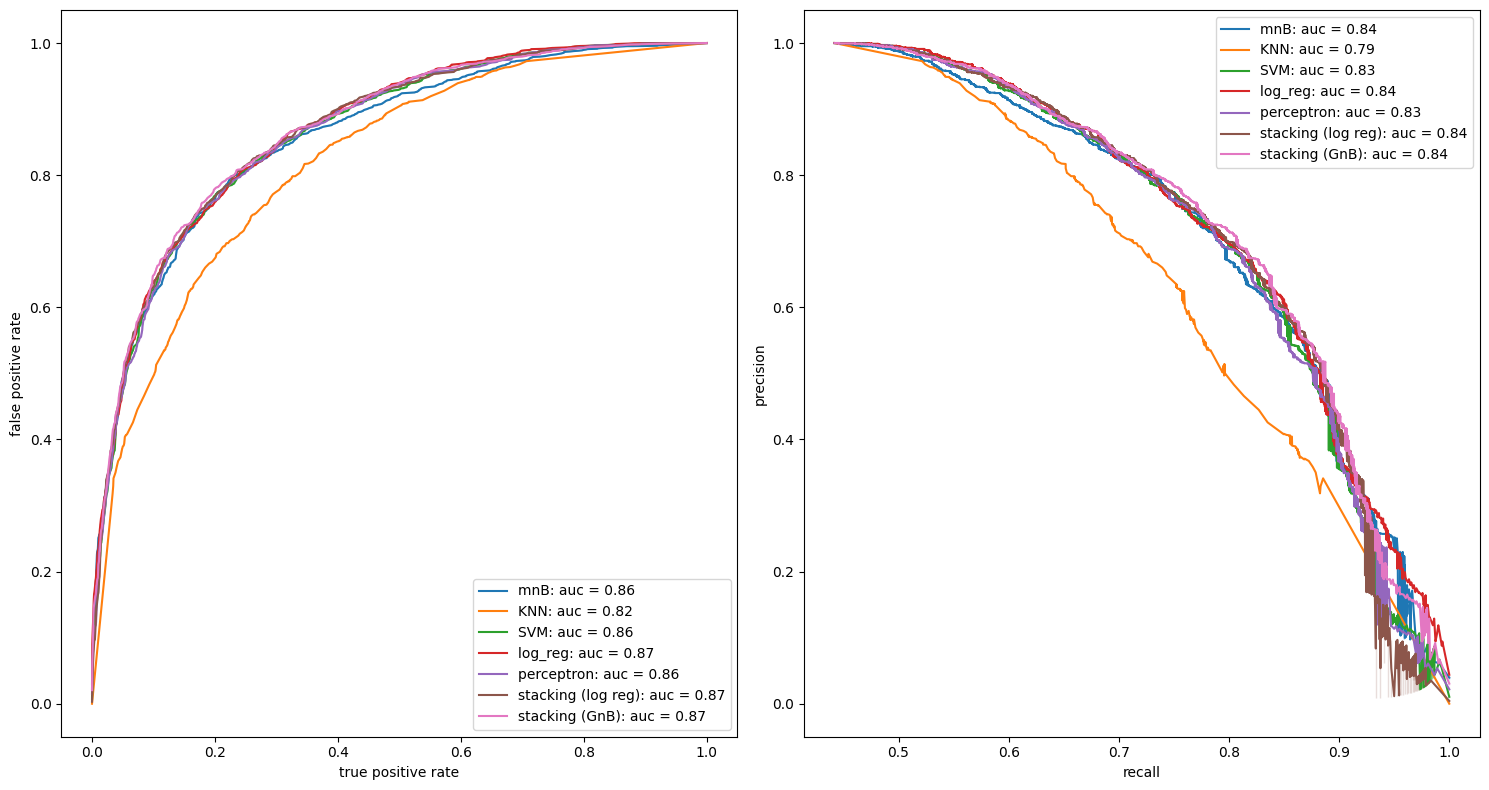

In [55]:
labels = ['mnB', 'KNN', 'SVM', 'log_reg', 'perceptron', 'stacking (log reg)', 'stacking (GnB)']

plot_roc_pr(y_test, [np.transpose(y_probas)[1] for y_probas in [*list(y_probas_calibrated.values()), *list(y_probas_stacking.values())]], labels, save="roc_pr.jpg", save_format="jpg")


## Feature importance

The four linear models we have looked at -- linear regression, logistic regression, SVM and perceptron -- provide coefficients that can be used to represent the predicted impact of a token on the view count. Let's get the model coefficients:

Which features have the highest coefficients, i.e. the greatest predictive power according to the linear model? I'll first create a function that converts the co-ordinate index of the input feature vector into the features of the original data, which were the video categories and the n-gram vocabularies of the channel and video titles and video descriptions:

In [ ]:
get_feature_by_index(10000)
coefs_sorted_indices = np.argsort(ridge_regressor.coef_)
coefficients_regressor = []

for n in tqdm(range(len(coefs_sorted_indices))):
    idx = coefs_sorted_indices[-1-n]
    feature = get_feature_by_index(idx)
    coefficients_regressor.append({'feature_type': feature['feature_type'], 'feature': feature['feature'], 'coefficient': ridge_regressor.coef_[idx]})

pd.set_option('display.max_rows', 200)
pd.DataFrame(coefficients_regressor).sort_values('coefficient', ascending=False).head(200)

pd.DataFrame(coefficients_regressor).sort_values('coefficient', ascending=True).head(200)

In [ ]:
vectorizer_vocabularies = {texts: vectorizers[texts].get_feature_names_out() for texts in vectorizers}

categories = onehotencoder.categories_[0]
N_categories = len(categories)
vocab_sizes = {texts: len(vectorizer_vocabularies[texts]) for texts in vectorizer_vocabularies}

def get_feature_by_index(idx):
    if idx < N_categories:
        return {'feature_type': 'video_category', 'feature': categories[idx]}
    if idx < N_categories + vocab_sizes['channel_titles']:
        word = vectorizer_vocabularies['channel_titles'][idx - N_categories]
        return {'feature_type': 'channel_title_n_gram', 'feature': tokenizer_decode(word.split(), 'channel_titles')}
    if idx < N_categories + vocab_sizes['channel_titles'] + vocab_sizes['video_titles']:
        word = vectorizer_vocabularies['video_titles'][idx - N_categories - vocab_sizes['channel_titles']]
        return {'feature_type': 'video_title_n_gram', 'feature': tokenizer_decode(word.split(), 'video_titles')}
    else:
        word = vectorizer_vocabularies['video_descriptions'][idx - N_categories - vocab_sizes['channel_titles'] - vocab_sizes['video_titles']]
        return {'feature_type': 'video_description_n_gram', 'feature': tokenizer_decode(word.split(), 'video_descriptions')}

In [ ]:
linear_models_coefs = []

linear_models_coefs.append(ridge_regressor.coef_)
for model_name in ['SVM', 'log_reg', 'perceptron']:
    linear_models_coefs.append(models[model_name].coef_[0])

linear_models_coefs = np.array(linear_models_coefs)

In [ ]:
def rank_array(values, descending=True):
    sorted_indices = np.argsort(values)
    if descending:
        sorted_indices = [sorted_indices[len(values)-1-idx] for idx in range(len(values))]
    ranks = {idx:rank for rank,idx in enumerate(sorted_indices)}
    return sorted_indices, ranks 

In [ ]:
ranks_list = []

for i in range(4):
    _, ranks = rank_array(linear_models_coefs[i])
    ranks_list.append(ranks)

In [ ]:
feature_ranks = []

for idx in tqdm(range(len(linear_models_coefs[0]))):
    feature = get_feature_by_index(idx)
    feature_ranks.append({'feature_type': feature['feature_type'], 'feature': feature['feature'], 'rank (lin reg)': ranks_list[0][idx], 'rank (SVM)': ranks_list[1][idx], 'rank (log reg)': ranks_list[2][idx], 'rank (perceptron)': ranks_list[3][idx]})

In [ ]:
feature_ranks = pd.DataFrame(feature_ranks).sort_values('rank (lin reg)')
feature_ranks.head(200)

The accuracy of the models makes any interpretation of the feature rankings difficult. What's worse, the linear classifiers disagree substantially, despite having similar accuracies.